# Assessing the Performance of Lolopy
Transferring data to and from JVM is remarkably costly. In this notebook, we quantify how costly the transfer is compared to the training as a function of training set size. We will use a standard ML problem: predicting glass-forming ability of ternary metallic alloys.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from matminer.datasets.dataset_retrieval import load_dataset
from matminer.featurizers.composition import ElementProperty
from lolopy.learners import RandomForestRegressor
from lolopy.loloserver import find_lolo_jar
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from scipy.interpolate import interp1d
from subprocess import PIPE, Popen
from pymatgen import Composition
from time import perf_counter
import pandas as pd
import numpy as np

Make a timing function. 

In [2]:
def time_function(fun, n, *args, **kwargs):
    """Run a certain function and return timing
    
    Args:
        fun (function): Function to be evaluated
        n (int): Number of times to run function
        args: Input to function
    Returns:
        ([float]) Function run times
    """
    
    times = []
    for i in range(n):
        st = perf_counter()
        fun(*args, **kwargs)
        times.append(perf_counter() - st)
    return times

## Create the Dataset
We'll use the Materials Project dataset

Pull down the dataset

In [3]:
data = load_dataset('mp_nostruct')

Eliminate entries without formulas

In [4]:
data = data[~ data['formula'].isnull()]

Downselect to $10^3$ entries

In [5]:
data = data.sample(1000)

Generate some features

In [6]:
X = np.array(ElementProperty.from_preset('magpie').featurize_many(data['formula'].apply(Composition), pbar=False))

In [7]:
y = data['e_form'].values

Make a function to run the scala benchmark

In [8]:
lolojar = find_lolo_jar()

In [9]:
def get_scala_timings(X, y, X_run):
    """Train a RF with standard settings using Lolo, generate uncertainties for whole dataset, report timings
    
    Args:
        X, y (ndarray): Training dataset
        X_run (ndarray): Dataset to evaluate
    Returns:
        train, expected, uncertainty (float): Training time, expected and uncertainty evaluation times
    """
    np.savetxt('train.csv', np.hstack((X, y[:, None])), delimiter=',')
    np.savetxt('run.csv', np.hstack((X_run, np.zeros((len(X_run), 1)))), delimiter=',')
    p = Popen('scala -J-Xmx8g -cp {} scala-benchmark.scala train.csv run.csv'.format(lolojar), stdout=PIPE, 
         stderr=PIPE, shell=True)
    
    result = p.stdout.read().decode()
    return map(float, result.split(','))

In [10]:
scala_train, scala_expect, scala_uncert = get_scala_timings(X, y, X)

In [11]:
print('Lolo train time:', scala_train)

Lolo train time: 25.0268002725


In [12]:
print('Lolo apply time', scala_expect + scala_uncert)

Lolo apply time 5.184949755083333


## Profile Fitting the Model
We are looking to comprae the total time for fitting a model to the time required to send data over

In [13]:
model = RandomForestRegressor(num_trees=len(X))

Fit the model 16 times, measure the times

In [14]:
rf_fit = time_function(model.fit, 16, X, y)
print('Average fit time:', np.mean(rf_fit))

Average fit time: 25.836265772373736


Run only transfering the data to Java, record the time

In [15]:
x_java, _ = model._convert_train_data(X, y, None)

In [16]:
rf_transfer = time_function(model._convert_train_data, 16, X, y)
print('Average transfer time:', np.mean(rf_transfer))

Average transfer time: 0.024832841125316918


Compute uncertainities

In [17]:
rf_apply = time_function(model.predict, 16, X, return_std=True)
print('Average predict time:', np.mean(rf_apply))

Average predict time: 4.532787880501928


In [18]:
rf_apply_transfer = time_function(model._convert_run_data, 16, X)
print('Average transfer time for prediction:', np.mean(rf_apply_transfer))

Average transfer time for prediction: 0.03166484831672278


## Time Scikit-Learn
Compare against a scikit-learn model with the same amount of trees as Lolo.

In [19]:
sk_model = SKRFRegressor(n_estimators=len(X), n_jobs=-1)

In [20]:
sk_train = time_function(sk_model.fit, 16, X, y)

In [21]:
print('Sklearn fitting time:', np.mean(sk_train))

Sklearn fitting time: 6.492418694690059


## Compare as a Function of Scale
Measure the performance of each model as a function of training/test set size

In [22]:
results = []
for n in tqdm(np.logspace(1, np.log10(len(X)), 8, dtype=int)):
    # Initialize output
    r = {'n': n}
    
    # Get the training and test set sizes
    X_n = X[:n, :]
    y_n = y[:n]
    
    # Time using lolo via Scala
    scala_train, scala_expect, scala_uncert = get_scala_timings(X_n, y_n, X)
    r['scala_train'] = scala_train
    r['scala_apply'] = scala_expect
    r['scala_apply_wuncert'] = scala_expect + scala_uncert
    
    # Time using lolo via lolopy
    model.set_params(num_trees=len(X_n))
    
    r['lolopy_train'] = np.mean(time_function(model.fit, 16, X_n, y_n))
    r['lolopy_train_transfer'] = np.mean(time_function(model._convert_train_data, 16, X_n, y_n))
    
    r['lolopy_apply'] = np.mean(time_function(model.predict, 16, X, return_std=False))
    r['lolopy_apply_wuncert'] = np.mean(time_function(model.predict, 16, X, return_std=True))
    r['lolopy_apply_transfer'] = np.mean(time_function(model._convert_run_data, 16, X))
    
    model.clear_model()  # To save memory
    
    # Time using RF
    sk_model = SKRFRegressor(n_estimators=n)
    
    r['sklearn_fit'] = np.mean(time_function(sk_model.fit, 16, X_n, y_n))
    r['sklearn_apply'] = np.mean(time_function(sk_model.predict, 16, X))
    
    # Append results and continue
    results.append(r)

In [23]:
results = pd.DataFrame(results)

In [24]:
results

,lolopy_apply,lolopy_apply_transfer,lolopy_apply_wuncert,lolopy_train,lolopy_train_transfer,n,scala_apply,scala_apply_wuncert,scala_train,sklearn_apply,sklearn_fit
0,0.116662,0.024391,0.165237,0.017087,0.003188,10,0.015996,0.035499,0.005603,0.001232,0.006404
1,0.133029,0.024051,0.189982,0.016471,0.002876,19,0.029241,0.062266,0.010618,0.002103,0.015835
2,0.168782,0.026943,0.255486,0.036207,0.003416,37,0.053957,0.124907,0.027915,0.004003,0.038460
3,0.222436,0.029697,0.319998,0.099397,0.004629,71,0.118092,0.281287,0.082423,0.008115,0.128532
4,0.324749,0.047900,0.477770,0.361892,0.005894,138,0.223314,0.524047,0.334785,0.016721,0.472197
5,0.542687,0.023511,0.803255,1.476095,0.013816,268,0.410609,1.031157,1.355419,0.037041,1.944339
6,0.911938,0.028466,1.665230,6.058513,0.017012,517,0.821408,2.295356,5.728549,0.081465,7.859019
7,1.739875,0.030233,4.498204,21.606862,0.036226,1000,1.426820,5.280560,24.840871,0.187823,31.290804


Plot the training results. The blue shading is the data transfer time

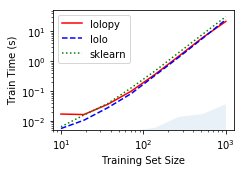

In [25]:
fig, ax = plt.subplots()

ax.fill_between(results['n'], results['lolopy_train_transfer'], 0.001, alpha=0.1)

ax.loglog(results['n'], results['lolopy_train'], 'r', label='lolopy')
ax.loglog(results['n'], results['scala_train'], 'b--', label='lolo')
ax.loglog(results['n'], results['sklearn_fit'], 'g:', label='sklearn')

ax.set_ylim(0.005, max(ax.get_ylim()))

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Train Time (s)')

ax.legend()
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig('training-performance.png')

Plot the evaluation speed. Note that the number of trees scales with the training set size (hence the decrease in speed with training set size)

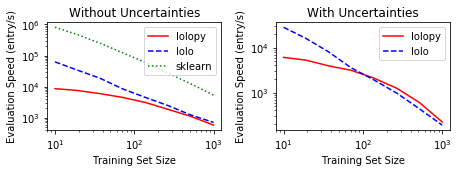

In [26]:
fig, axs = plt.subplots(1, 2)

# Plot results without uncertainties
axs[0].loglog(results['n'], len(X)  / results['lolopy_apply'], 'r', label='lolopy')
axs[0].loglog(results['n'], len(X) / results['scala_apply'], 'b--', label='lolo')
axs[0].loglog(results['n'], len(X) / results['sklearn_apply'], 'g:', label='sklearn')
axs[0].set_title('Without Uncertainties')

# Plot results with uncertainities
axs[1].loglog(results['n'], len(X)  / results['lolopy_apply_wuncert'], 'r', label='lolopy')
axs[1].loglog(results['n'], len(X) / results['scala_apply_wuncert'], 'b--', label='lolo')
axs[1].set_title('With Uncertainties')

for ax in axs:

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Evaluation Speed (entry/s)')

    ax.legend()
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
fig.savefig('evaluation-performance.png')

Verify that performance is within acceptable bounds: Less than a 2x slowdown for model training or evaluation at a training set size of 100 entries.

In [27]:
lolopy_timing = interp1d(results['n'], results['lolopy_train'])
lolo_timing = interp1d(results['n'], results['scala_train'])
slowdown = lolopy_timing(100) / lolo_timing(100)
print('Training slowdown: {:.2f}'.format(slowdown))
assert slowdown < 2

Training slowdown: 1.11


In [28]:
lolopy_timing = interp1d(results['n'], results['lolopy_apply'])
lolo_timing = interp1d(results['n'], results['scala_apply'])
slowdown = lolopy_timing(100) / lolo_timing(100)
print('Evaluation without uncertainties slowdown: {:.2f}'.format(slowdown))
assert slowdown < 2

Evaluation without uncertainties slowdown: 1.63


In [29]:
lolopy_timing = interp1d(results['n'], results['lolopy_apply_wuncert'])
lolo_timing = interp1d(results['n'], results['scala_apply_wuncert'])
slowdown = lolopy_timing(100) / lolo_timing(100)
print('Evaluation with uncertainties slowdown: {:.2f}'.format(slowdown))

Evaluation with uncertainties slowdown: 1.00
